# Example Notebook: Neuron Synapse Competition

## Load in and Wrangle Training Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Basic info on these dataframes

In [4]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

## 1. Merge Data

Before merging, we concatenate the feature weights and morphological embeddings into np.array's to decrease memory usage.

In [5]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [6]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [7]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

## Basic Exploratory Analysis

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Unbalanced Data

The outcomes, the adps that form a connection or synapse ('connected'==True) and the adps that do not synapse ('connected'==False), are unbalanced:

In [9]:
print("Number Connected (Synapses):",data['connected'].sum())

print("\nNumber Not Connected:",(~data['connected']).sum())

Number Connected (Synapses): 1366

Number Not Connected: 184466


The number of presynaptic neurons and postsynaptic neurons are also unbalanced:

In [10]:
print(f"All the adps are from {data['pre_nucleus_id'].nunique()} pre- neurons and {data['post_nucleus_id'].nunique()} post- neurons.")

All the adps are from 77 pre- neurons and 2663 post- neurons.


### Exploration: Synaptic Proximity Distance

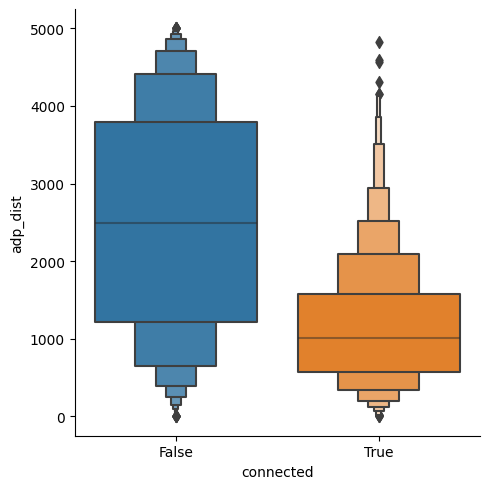

In [11]:
sns.catplot(data=data, x='connected', y='adp_dist', kind='boxen')

Neurons that form a synpase ('connected') tend to be closer together (smaller distance between pre- and post-synaptic ADP - 'adp_dist').

## Example: Basic Feature Engineering

### Exploration: Neurons that form a synpase tend to have similar functional neural responses

Neurons in the visual cortex each respond differently to visual stimuli.  This is often captured by a neuron's tuning function, or the visual features that drive a neuron to fire.  The feature weight vectors ('feature_weights') are a kind of summary of each neuron's tuning function.  Neuroscience suggests that neurons with similar tuning are slightly more likely to be connected.  To assess this, we would need to engineer a new feature that capture the tuning similarity of the pre- and post- synaptic neurons for each ADP.  (See the documentation for more details).  

In [12]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    return abs(dendriticX - axonalX)
def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    return abs(dendriticY - axonalY)
def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    return abs(dendriticZ - axonalZ)

def EDax_denDist(row):
#def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    #return abs(dendriticX - axonalX)
#def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    #return abs(dendriticY - axonalY)
#def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    #return abs(dendriticZ - axonalZ)
    return ((dendriticX - axonalX)**2
            + (dendriticY - axonalY)**2
            + (dendriticZ - axonalZ)**2)**(1/2)

def EDpre_postnucleusDist(row):
    preNucleusX = row["pre_nucleus_x"]
    preNucleusY = row["pre_nucleus_y"]
    preNucleusZ = row["pre_nucleus_z"]

    postNucleusX = row["post_nucleus_x"]
    postNucleusY = row["post_nucleus_y"]
    postNucleusZ = row["post_nucleus_z"]
    return np.sqrt((preNucleusX-postNucleusX)**2
                   + (preNucleusY-postNucleusY)**2
                   + (preNucleusZ-postNucleusZ)**2)

def thetaDiff(row):
    pre_orientation_vector_X = row["axonal_coor_x"] - row["pre_nucleus_x"]
    pre_orientation_vector_Y = row["axonal_coor_y"] - row["pre_nucleus_y"]
    pre_orientation_vector_Z = row["axonal_coor_z"] - row["pre_nucleus_z"]

    post_orientation_vector_X = row["dendritic_coor_x"] - row["post_nucleus_x"]
    post_orientation_vector_Y = row["dendritic_coor_y"] - row["post_nucleus_y"]
    post_orientation_vector_Z = row["dendritic_coor_z"] - row["post_nucleus_z"]

    numerator = (pre_orientation_vector_X
                 * post_orientation_vector_X
                 + pre_orientation_vector_Y * post_orientation_vector_Y
                 + pre_orientation_vector_Z * post_orientation_vector_Z
                 )
    denominator = (np.sqrt(pre_orientation_vector_X**2
                    + pre_orientation_vector_Y**2
                    + pre_orientation_vector_Z**2)
                    * (np.sqrt(post_orientation_vector_X**2
                    + post_orientation_vector_Y**2
                    + post_orientation_vector_Z**2))
                   )
    cos_theta = numerator / denominator
    actual_angle = np.arccos(cos_theta)*(180/np.pi)
    return actual_angle

#cosine similarity function
def row_morphEmbed_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# location slicer relative to lop left of monitor
def preRadialLocation(row):
    pre = row["pre_rf_x"]
    post = row["pre_rf_y"]
    return np.sqrt(pre**2 * post**2)

def postRadialLocation(row):
    pre = row["post_rf_x"]
    post = row["post_rf_y"]
    return np.sqrt(pre**2 * post**2)

def oracleDiff(row):
    pre = row["pre_oracle"]
    post = row["post_oracle"]
    return pre * post

def testScoreDiff(row):
    pre = row["pre_test_score"]
    post = row["post_test_score"]
    return pre * post

In [13]:

# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings
data["morphEm_similarity"] = data.apply(row_morphEmbed_similarity, axis=1)
# compute the difference between the X-coordinates
data["coorX_difference"] = data.apply(xCoorDifference, axis=1)
# compute the difference between the Y-coordinates
data["coorY_difference"] = data.apply(yCoorDifference, axis=1)
# compute the difference between the Z-coordinates
data["coorZ_difference"] = data.apply(zCoorDifference, axis=1)
# Theta between 2 neurons
data["theta_btwn_2neurons"] = data.apply(thetaDiff, axis =1)
# 3D distance between axon and dendrite
data["3Dax_denDist"] = data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
data["3Dpre_postNucleusDist"] = data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location
data["preRadialLocation"] = data.apply(preRadialLocation, axis=1)
# Post radial location
data["postRadialLocation"] = data.apply(postRadialLocation, axis=1)
# Combined Oracle Score of Pre-synaptic and Post-synaptic Neurons:
data["Combined_oracle"] = data.apply(oracleDiff, axis=1)
# pre and post test score difference
data["Combined_testScore"] = data.apply(testScoreDiff, axis=1)

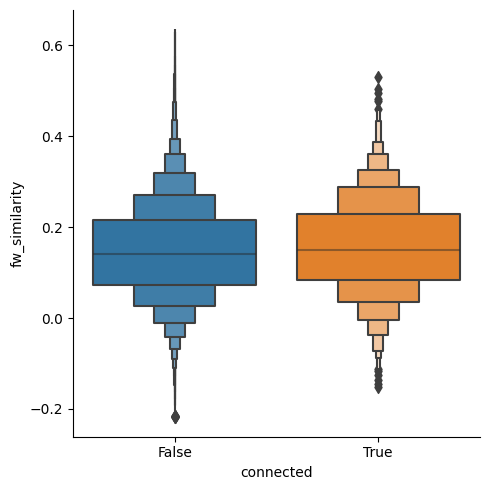

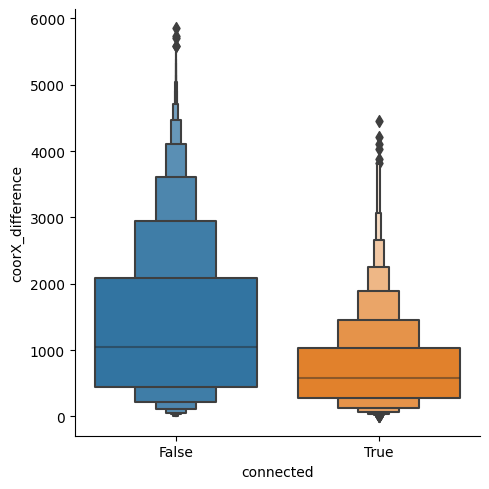

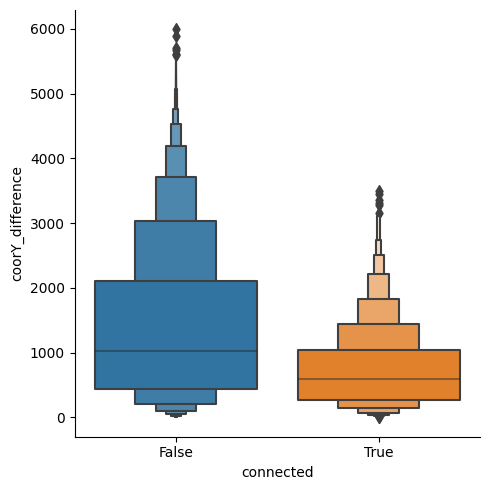

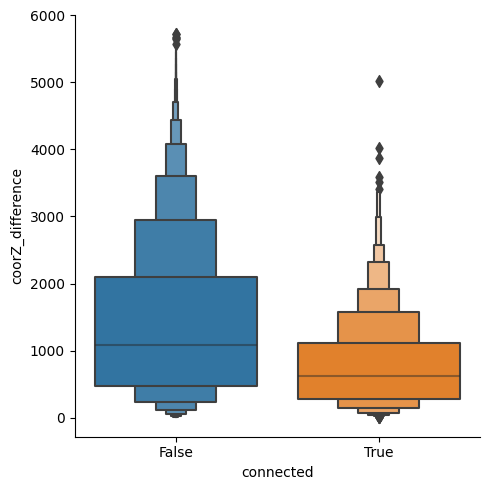

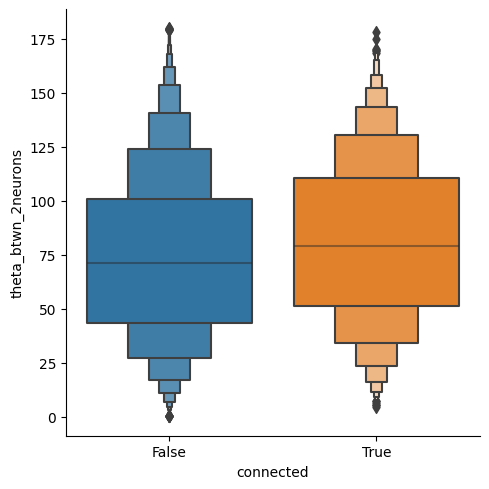

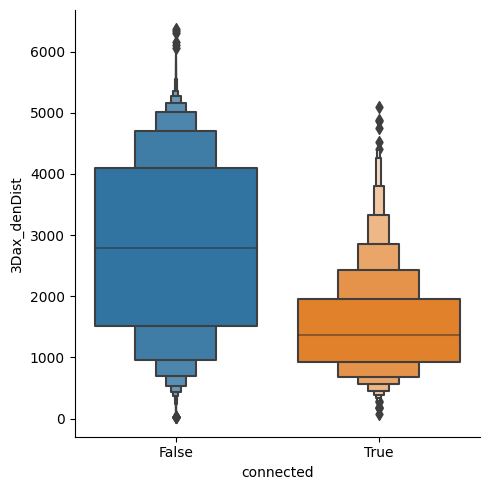

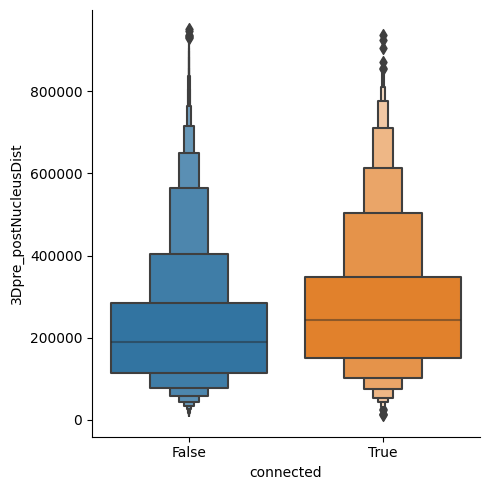

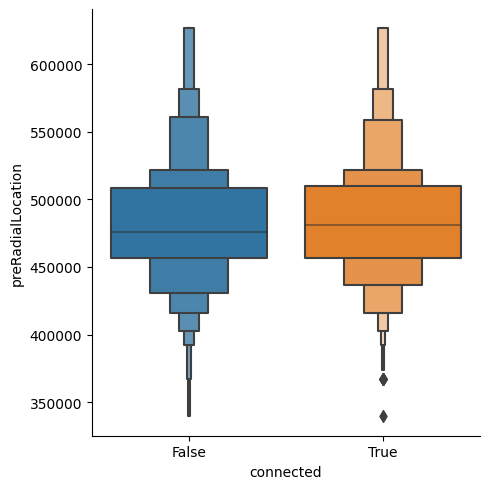

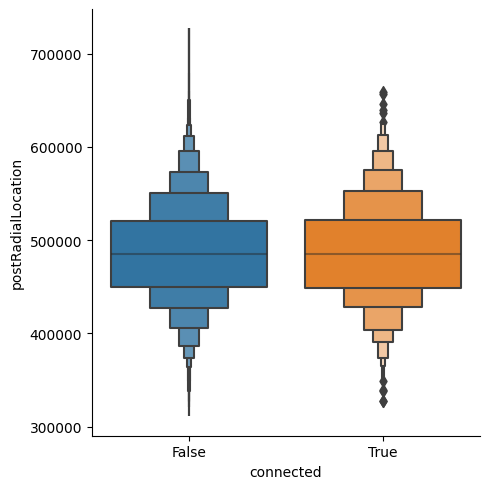

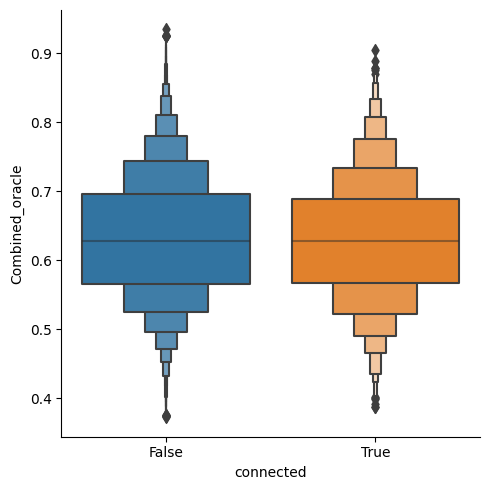

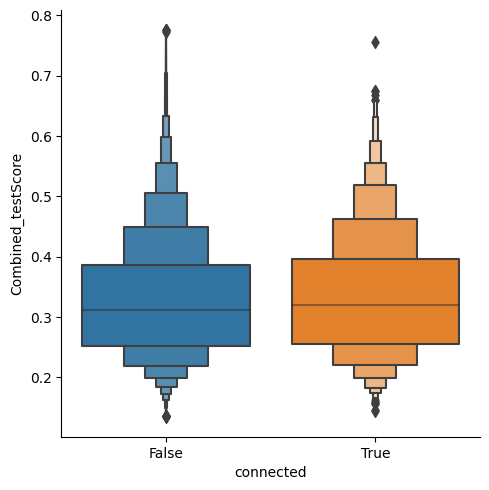

In [14]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='coorX_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorY_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorZ_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='theta_btwn_2neurons', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dax_denDist', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dpre_postNucleusDist', kind='boxen')
sns.catplot(data=data, x='connected', y='preRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='postRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_oracle', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_testScore', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [15]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

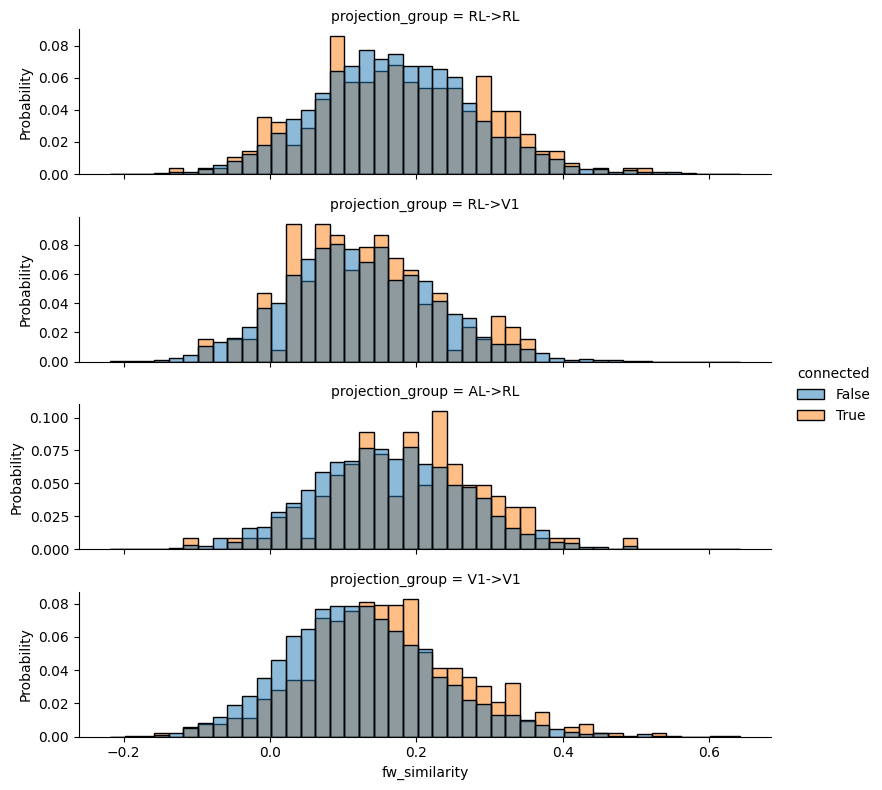

In [16]:
# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'),
    x='fw_similarity',
    hue='connected',
    row='projection_group',
    common_norm=False,
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False}
)

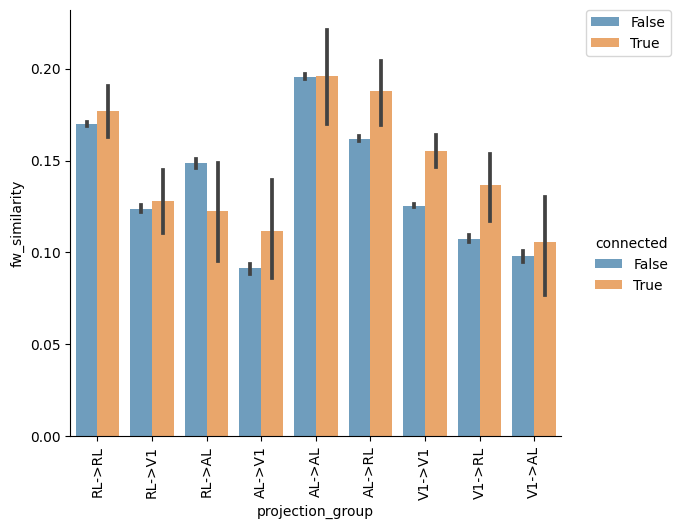

In [17]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

Above are how new features were engineered also shown are how these are related to neuron connectivity. The nececity to explore and engineer many other possible features were crucial in this competition.

### Balanced Accuracy Metric

Sensitivity = True Positive Rate = True Positive / (True Positive + False Negative)
Specificity = True Negative Rate = True Negative / (True Negative + False Positive)

Balanced Accuracy = (Sensitivity + Specificity)/2

## 1.1. Final Merging of Columns

### Load and Merge Leaderboard Data

In [18]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [19]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [20]:
lb_data.shape
lb_data.head

<bound method NDFrame.head of           ID  axonal_coor_x  axonal_coor_y  axonal_coor_z  dendritic_coor_x  \
0          0         527499         544761         912282            529457   
1          1        1269890         471870         837816           1271230   
2          2         666057         469875         925239            665387   
3          3         696633         453516         925806            696648   
4          4         567525         585921         888426            570714   
...      ...            ...            ...            ...               ...   
42588  42588         765513         818622         870114            766346   
42589  42589         784476         609000         828177            782564   
42590  42590         766038         773808         861693            763428   
42591  42591         738276         614460         855099            741617   
42592  42592         769314         457443         874419            771959   

       dendritic_coor

## 1.2. Leaderboard dataframe

All engineered features are also added to the Leaderboard dataframe.

In [21]:
# compute the cosine similarity between the pre- and post- feature weights
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings
lb_data["morphEm_similarity"] = lb_data.apply(row_morphEmbed_similarity, axis=1)
# compute the cosine similarity between the X-coordinates
lb_data["coorX_difference"] = lb_data.apply(xCoorDifference, axis=1)
# compute the cosine similarity between the Y-coordinates
lb_data["coorY_difference"] = lb_data.apply(yCoorDifference, axis=1)
# compute the cosine similarity between the Z-coordinates
lb_data["coorZ_difference"] = lb_data.apply(zCoorDifference, axis=1)
lb_data["theta_btwn_2neurons"] = lb_data.apply(thetaDiff, axis = 1)
# 3D distance between axon and dendrite
lb_data["3Dax_denDist"] = lb_data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
lb_data["3Dpre_postNucleusDist"] = lb_data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location
lb_data["preRadialLocation"] = lb_data.apply(preRadialLocation, axis=1)
# Post radial location
lb_data["postRadialLocation"] = lb_data.apply(postRadialLocation, axis=1)
# pre and post oracle difference
lb_data["Combined_oracle"] = lb_data.apply(oracleDiff, axis=1)
# pre and post test score difference
lb_data["Combined_testScore"] = lb_data.apply(testScoreDiff, axis=1)

## 2.0. Feature Importance: Logistic Regression

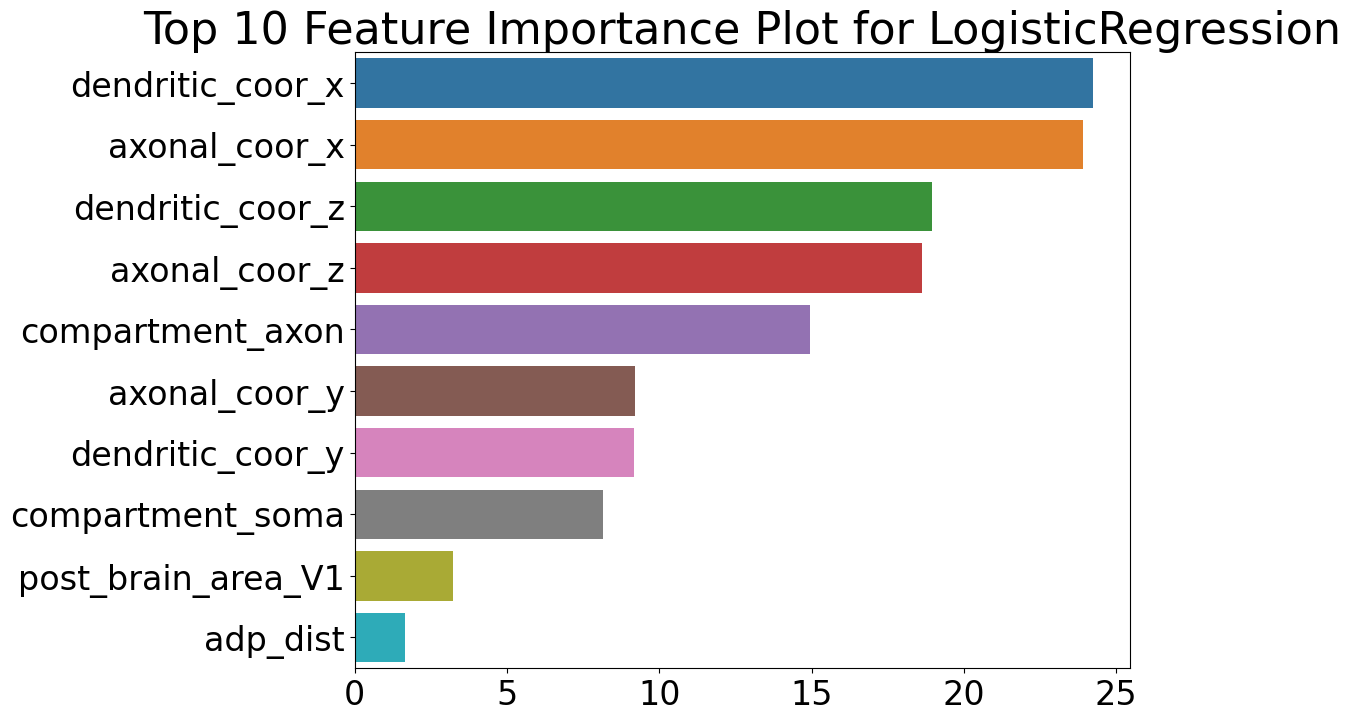

<Figure size 1000x800 with 0 Axes>

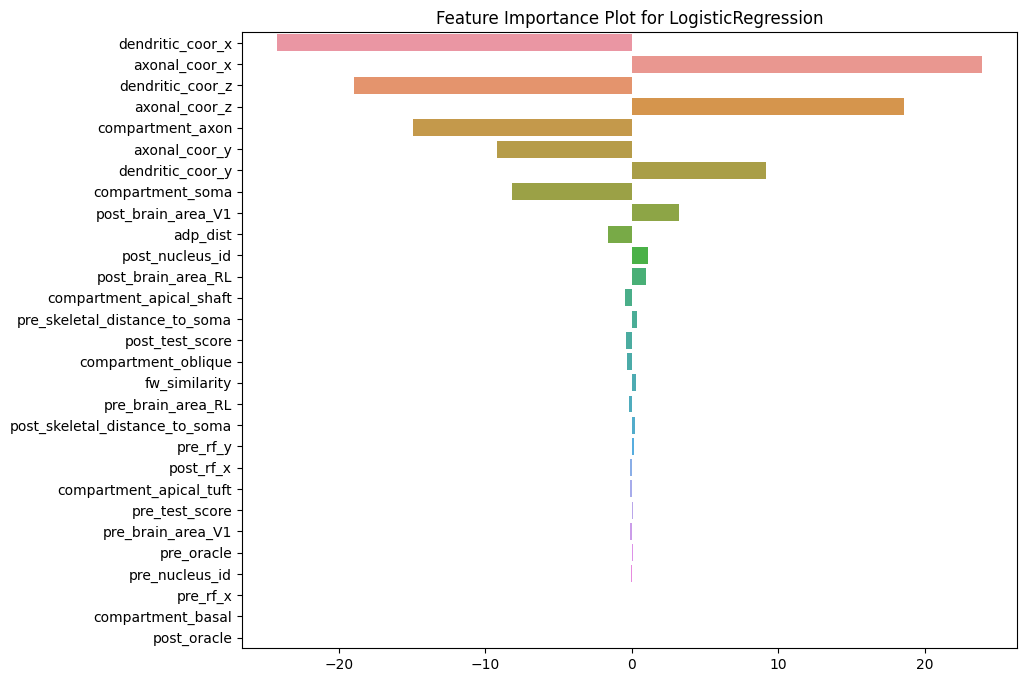

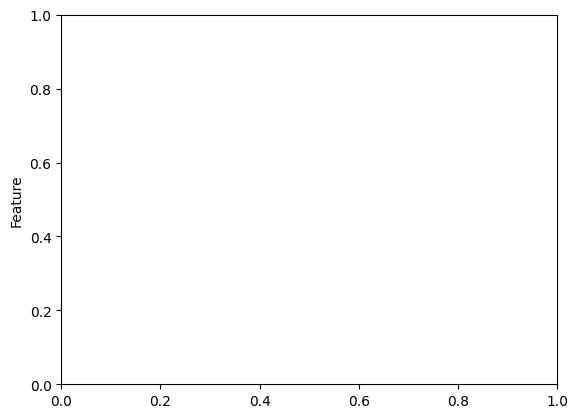

Model: LogisticRegression
Best Parameters: {'model__C': 100.0, 'model__class_weight': 'balanced'}
Accuracy: 0.7469
Balanced Accuracy: 0.7423
Confusion Matrix:
[[124004  42014]
 [   323    908]]




'\n\n# Final Predictions using the best model (as an example, I am choosing Logistic Regression, but this can be changed)\nfinal_model_name = \'LogisticRegression\'\nfinal_model = GridSearchCV(Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'model\', models_and_parameters[final_model_name][\'model\'])\n]), models_and_parameters[final_model_name][\'params\'], cv=5, scoring=\'balanced_accuracy\', n_jobs=-1)\n\n# Print all evaluation metrics\nfinal_model.fit(X_resampled, y_resampled)\nfor model, metrics in evaluation_results.items():\n    print(f"{model}:")\n    for key, value in metrics.items():\n        print(f"{key}: {value}")\n    print("\n")\nprint(f"{model_name}:")\nprint(f"Best hyperparameters: {clf.best_params_}")\nprint(f"Accuracy: {accuracy:.4f}")\nprint(f"Confusion Matrix: {conf_matrix}")\nprint(f"Balanced Accuracy: {balanced_accuracy:.4f}")\nprint("\n")\n\nlb_data["pred"] = final_model.predict(lb_data[predict_features])\nlb_data["connected"] = lb_data["pred"] > .5\n'

In [30]:
!pip install hmmlearn
!pip install sklearn-crfsuite
!pip install minisom

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from xgboost import XGBClassifier
from minisom import MiniSom
import matplotlib.pyplot as plt
from hmmlearn import hmm
import seaborn as sns
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)

# Feature list
predict_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y",
            "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
            "axonal_coor_y", "axonal_coor_z", "post_skeletal_distance_to_soma",
            "pre_skeletal_distance_to_soma", "pre_oracle", "pre_test_score",
            "pre_rf_x", "pre_rf_y", "post_oracle", "post_test_score",
            "post_rf_x", "compartment", "pre_brain_area", "post_brain_area"]

X_train, X_test, y_train, y_test = train_test_split(data[predict_features], data["connected"], test_size=0.9, random_state=5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), slice(0, -3)),
        ('cat', OneHotEncoder(drop='first'), [predict_features.index(feat) for feat in ["compartment", "pre_brain_area", "post_brain_area"]])
    ])

evaluation_results = {}  # to store evaluation metrics for each model

resampler =RandomOverSampler(random_state=5)
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

models_and_parameters = {

    'LogisticRegression': {
        'model': LogisticRegression(random_state=5, max_iter=5000),
        'params': {'model__C': np.logspace(-2, 2, 5), 'model__class_weight': [None, 'balanced']}
    },
}

X_temp = preprocessor.fit_transform(X_resampled)

for model_name, mp in models_and_parameters.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])

    # Grid search
    clf = GridSearchCV(pipeline, mp['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    evaluation_results[model_name] = {
        'Best Parameters': clf.best_params_,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'Confusion Matrix': conf_matrix
    }

    best_model = clf.best_estimator_.named_steps['model']

    # Feature Importance or Coefficients
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])

    # Sorting and selecting top 10 features
    sorted_idx = np.argsort(importances)[-10:][::-1]

    # Handling feature names after one-hot encoding for plotting
    feature_names_after_encoding = (clf.best_estimator_.named_steps['preprocessor']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(predict_features[-3:]))
    all_feature_names = np.concatenate([predict_features[:-3], feature_names_after_encoding])

    # Selecting top 10 feature names
    top_10_feature_names = all_feature_names[sorted_idx]

    #   Plotting
    plt.figure(figsize=(10, 8))
    sns.barplot(y=top_10_feature_names, x=importances[sorted_idx])
    plt.title(f"Top 10 Feature Importance Plot for {model_name}", fontsize=32)
    plt.xticks(fontsize=24)  # Increase font size
    plt.yticks(fontsize=24)  # Increase font size
    plt.show()

    best_model = clf.best_estimator_.named_steps['model']

    # Feature Importance / Coefficients using simple bar plots
    plt.figure(figsize=(10, 8))

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 8))
    sns.barplot(y=all_feature_names[sorted_idx], x=importances[sorted_idx])
    plt.title(f"Top 10 Feature Importance Plot for {model_name}")
    plt.xticks(fontsize=24)  # Increase font size
    plt.yticks(fontsize=24)  # Increase font size
    plt.show()

elif hasattr(best_model, 'coef_'):
    coefficients = best_model.coef_[0]
    sorted_idx = np.argsort(np.abs(coefficients))[::-1]

    plt.figure(figsize=(10, 8))
    sns.barplot(y=all_feature_names[sorted_idx], x=coefficients[sorted_idx])
    plt.title(f"Feature Importance Plot for {model_name}")
    plt.show()

    plt.ylabel("Feature")
    #plt.gca().invert_yaxis()
    plt.show()


    # Printing the evaluation metrics below the plot
    print(f"Model: {model_name}")
    print(f"Best Parameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\n")

"""

# Final Predictions using the best model (as an example, I am choosing Logistic Regression, but this can be changed)
final_model_name = 'LogisticRegression'
final_model = GridSearchCV(Pipeline([
    ('preprocessor', preprocessor),
    ('model', models_and_parameters[final_model_name]['model'])
]), models_and_parameters[final_model_name]['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Print all evaluation metrics
final_model.fit(X_resampled, y_resampled)
for model, metrics in evaluation_results.items():
    print(f"{model}:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print("\n")
print(f"{model_name}:")
print(f"Best hyperparameters: {clf.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: {conf_matrix}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print("\n")

lb_data["pred"] = final_model.predict(lb_data[predict_features])
lb_data["connected"] = lb_data["pred"] > .5
"""

## 2.1. Feature Importance plot of Logistic Regression V.S. AdaBoost V.S. Perceptron, V.S. Bernoulli Naive Bayes V.S. QDA

LogisticRegression:
Best hyperparameters: {'model__C': 35.93813663804626, 'model__class_weight': None}
Accuracy: 0.7132587967146344
Balanced Accuracy: 0.75893085866758
Confusion Matrix:
[[52431 21151]
 [  110   455]]




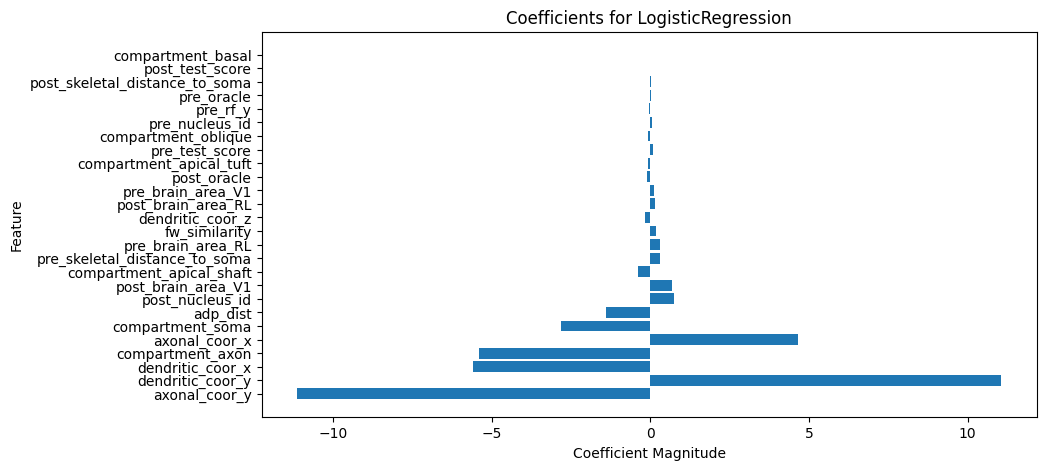

Perceptron:
Best hyperparameters: {'model__max_iter': 1000, 'model__tol': 0.001}
Accuracy: 0.7875301765411952
Balanced Accuracy: 0.6444299093925193
Confusion Matrix:
[[58111 15471]
 [  283   282]]




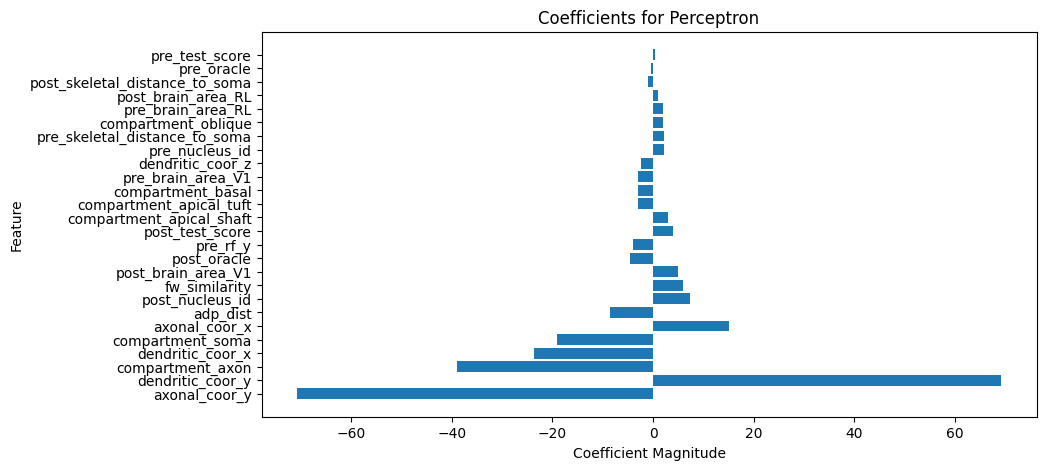

AdaBoostClassifier:
Best hyperparameters: {'model__learning_rate': 0.5, 'model__n_estimators': 100}
Accuracy: 0.6917339878889234
Balanced Accuracy: 0.7744306334056785
Confusion Matrix:
[[50805 22777]
 [   80   485]]




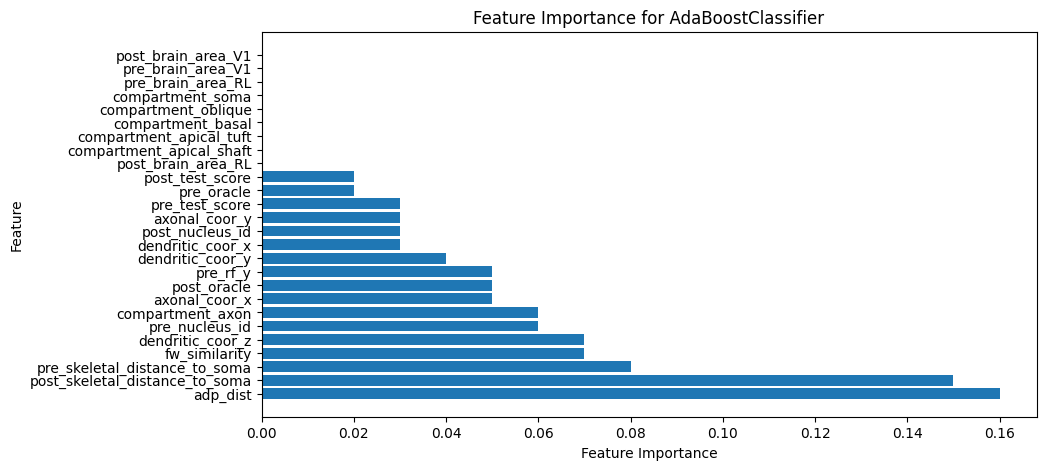

BernoulliNB:
Best hyperparameters: {'model__alpha': 1.0}
Accuracy: 0.6592714472601724
Balanced Accuracy: 0.7141667005421439
Confusion Matrix:
[[48448 25134]
 [  130   435]]


KNeighborsClassifier:
Best hyperparameters: {'model__n_neighbors': 3, 'model__weights': 'distance'}
Accuracy: 0.9795001820707513
Balanced Accuracy: 0.5251244232248989
Confusion Matrix:
[[72591   991]
 [  529    36]]


QuadraticDiscriminantAnalysis:
Best hyperparameters: {}
Accuracy: 0.5720123538376468
Balanced Accuracy: 0.7527492415300683
Confusion Matrix:
[[41884 31698]
 [   36   529]]


LinearDiscriminantAnalysis:
Best hyperparameters: {'model__solver': 'svd'}
Accuracy: 0.6874586969128893
Balanced Accuracy: 0.7608604860317175
Confusion Matrix:
[[50501 23081]
 [   93   472]]




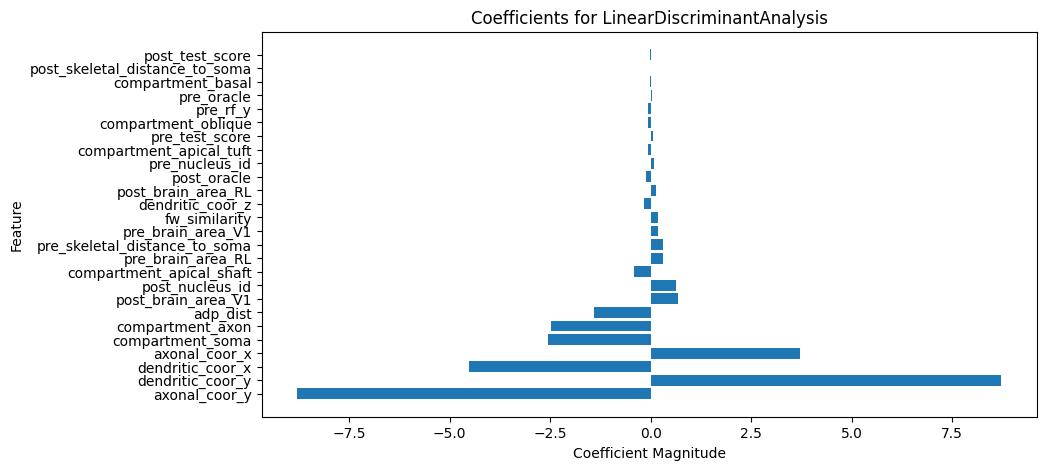

In [31]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from xgboost import XGBClassifier
from minisom import MiniSom
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np

# Feature list
predict_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y",
                   "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
                   "axonal_coor_y", "post_skeletal_distance_to_soma",
                   "pre_skeletal_distance_to_soma", "pre_oracle", "pre_test_score",
                   "pre_rf_y", "post_oracle", "post_test_score",
                   "compartment", "pre_brain_area", "post_brain_area"]

X_train, X_test, y_train, y_test = train_test_split(data[predict_features], data["connected"], test_size=0.399, random_state=5)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), slice(0, -3)),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), slice(-3, None))
    ])
resampler =RandomOverSampler(random_state=5)
X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

models_and_parameters = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=5, max_iter=5000),
        'params': {'model__C': np.logspace(-2, 2, 10), 'model__class_weight': [None, 'balanced']}
    },
    'Perceptron': {
        'model': Perceptron(),
        'params': {'model__max_iter': [1000, 5000], 'model__tol': [1e-3, 1e-4]}
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(),
        'params': {'model__n_estimators': [50, 100], 'model__learning_rate': [0.05, 0.1, 0.5]}
    },
    'MultinomialNB': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.1, 1.0, 10.0]}
    },
    'BernoulliNB': {
        'model': BernoulliNB(),
        'params': {'model__alpha': [0.1, 1.0, 10.0]}
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}
    },
    'QuadraticDiscriminantAnalysis': {
        'model': QuadraticDiscriminantAnalysis(),
        'params': {}
    },
    'LinearDiscriminantAnalysis': {
        'model': LinearDiscriminantAnalysis(),
        'params': {'model__solver': ['svd', 'lsqr']}
    },
    # ... Add other models similarly
}

X_temp = preprocessor.fit_transform(X_resampled)

if (X_temp < 0).any():
    del models_and_parameters['MultinomialNB']

for model_name, mp in models_and_parameters.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])

    # Grid search
    clf = GridSearchCV(pipeline, mp['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Output results
    print(f"{model_name}:")
    print(f"Best hyperparameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:}")
    print(f"Balanced Accuracy: {balanced_accuracy:}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    # Handling feature names after one-hot encoding for plotting
    feature_names_after_encoding = (clf.best_estimator_.named_steps['preprocessor']
                                    .named_transformers_['cat']
                                    .get_feature_names_out(predict_features[-3:]))
    all_feature_names = np.concatenate([predict_features[:-3], feature_names_after_encoding])

    best_model = clf.best_estimator_.named_steps['model']

    # Feature Importance / Coefficients
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 5))
        plt.barh(all_feature_names[sorted_idx], importances[sorted_idx])
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance for {model_name}")
        plt.show()

    elif hasattr(best_model, 'coef_'):
        coefficients = best_model.coef_[0]
        sorted_idx = np.argsort(np.abs(coefficients))[::-1]
        plt.figure(figsize=(10, 5))
        plt.barh(all_feature_names[sorted_idx], coefficients[sorted_idx])
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Feature")
        plt.title(f"Coefficients for {model_name}")
        plt.show()

# Predict directly using the pipeline (which includes the preprocessor)
lb_data["pred"] = clf.predict(lb_data[predict_features])
lb_data["connected"] = lb_data["pred"] > .5

## 3.0. Heatmap; Cluster Map via Logistic Regression; and Pair Plot of fitted degree-2 polynomial vis-à-vis Polynomial Regresssion

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from xgboost import XGBClassifier
from minisom import MiniSom
import matplotlib.pyplot as plt
from hmmlearn import hmm
import seaborn as sns
import numpy as np

# Feature list
predict_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y",
            "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
            "axonal_coor_y", "axonal_coor_z", "post_skeletal_distance_to_soma",
            "pre_skeletal_distance_to_soma", "pre_oracle", "pre_test_score",
            "pre_rf_x", "pre_rf_y", "post_oracle", "post_test_score",
            "post_rf_x", "compartment", "pre_brain_area", "post_brain_area"]

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(data[predict_features], data["connected"])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), slice(0, -3)),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), slice(-3, None))
    ])
preprocessed_data = preprocessor.fit_transform(data[predict_features])

models_and_parameters = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=5, max_iter=5000),
        'params': {'model__C': np.logspace(-2, 2, 10), 'model__class_weight': [None, 'balanced']}
    },
}

for model_name, mp in models_and_parameters.items():
    # Construct pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])

    # Grid search
    clf = GridSearchCV(pipeline, mp['params'], cv=5, scoring='balanced_accuracy', n_jobs=-1)
    clf.fit(X_resampled, y_resampled)

preprocessed_data = preprocessor.transform(data[predict_features])
columns_after_preprocessing = (predict_features[:-3] +
                              list(clf.best_estimator_.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .get_feature_names_out(predict_features[-3:])))

preprocessed_df = pd.DataFrame(preprocessed_data, columns=columns_after_preprocessing)

corr_matrix_all = preprocessed_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

if "connected" in data.columns:
    # Adding the 'connected' column to our preprocessed DataFrame for visualization
    preprocessed_df['connected'] = data["connected"]

sns.clustermap(preprocessed_df.drop('connected', axis=1),
               method='ward',
               cmap='coolwarm',
               standard_scale=1,
               figsize=(15, 15))
plt.show()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

# Draw the heatmap
sns.heatmap(corr_matrix_all, cmap='coolwarm',
                            vmax=1, vmin=-1, center=0,
                            square=True, linewidths=.5,
                            cbar_kws={"shrink": 0.75},
                            annot=True)

plt.title("Correlation Matrix for All Features")
plt.show()

if "connected" in data.columns:
    # Adding the 'connected' column to our preprocessed DataFrame for visualization
    preprocessed_df['connected'] = data["connected"]

    # Pair plot using the 'connected' column as hue
    sns.pairplot(preprocessed_df, hue="connected", kind='reg', plot_kws={'order': 2})
    plt.show()
else:
    print("The 'connected' column DNE in your data!")

## 4.0. XGBoost Feature Importance Plot

Best hyperparameters: {'model__colsample_bytree': 0.2, 'model__gamma': 0.001, 'model__learning_rate': 0.0001, 'model__max_depth': 6, 'model__n_estimators': 135, 'model__subsample': 1.0}
Accuracy: 0.7502242152466367
Balanced Accuracy: 0.7588880640782942


/var/folders/yb/qzkktnzj0pz942x9m0pfv2880000gn/T/ipykernel_3201/3030876310.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_feature_importances, y=top_feature_names, palette=palette)


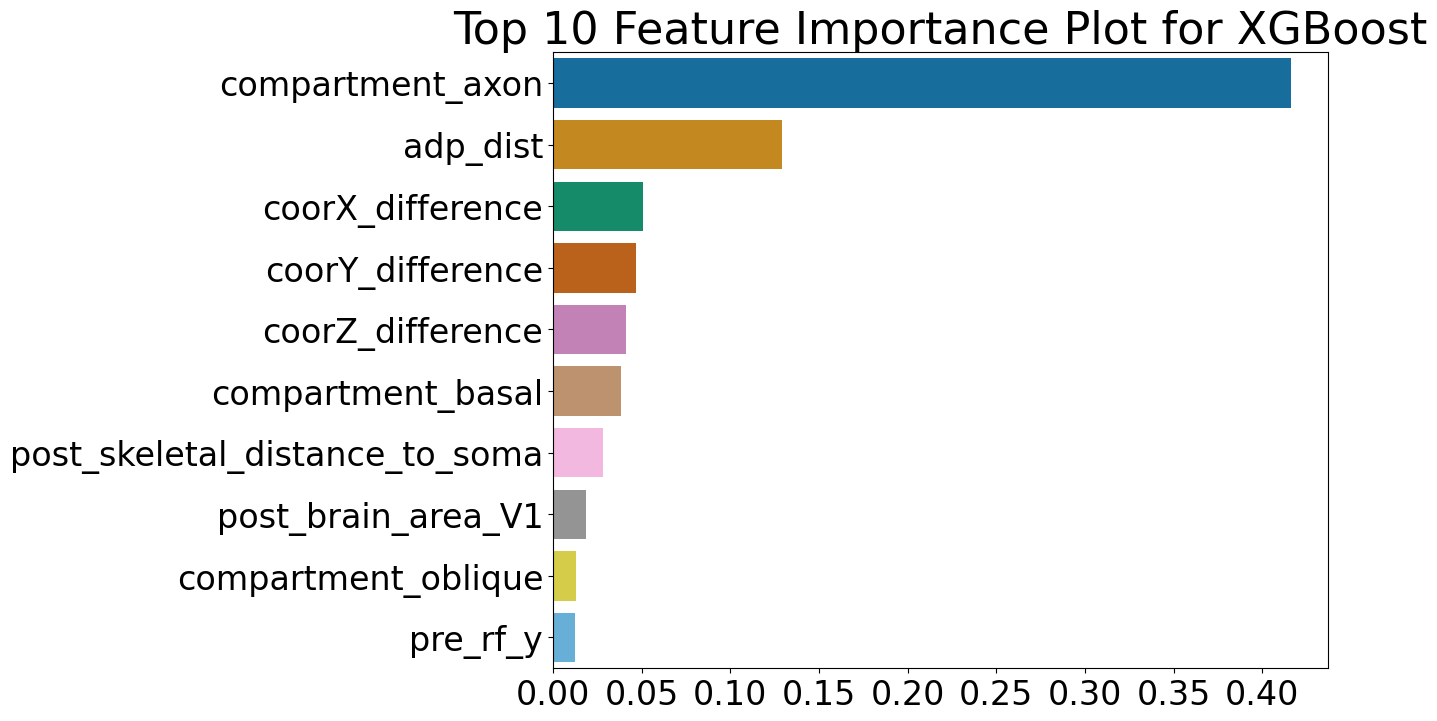

"\n# 4. Cluster Map instead of Dendrogram\nplt.figure(figsize=(15, 15))  # Adjust the figure size as needed\nsns.clustermap(preprocessed_df_train.corr(), method='ward', cmap='coolwarm', center=0,\n               linewidths=.75, figsize=(15, 15))\nplt.title('Cluster Map of Feature Correlation')\nplt.show()\n"

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import scipy.cluster.hierarchy as sch
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting features into numerical, categorical, and one to impute
numerical_features = ["coorZ_difference", "coorY_difference", "coorX_difference",
                    "adp_dist", "post_skeletal_distance_to_soma", "pre_rf_y", "pre_skeletal_distance_to_soma",
                    "dendritic_coor_x", "dendritic_coor_y", "fw_similarity", "post_nucleus_id",
                    "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x",
                    "axonal_coor_y", "axonal_coor_z",
                    "pre_test_score", "pre_rf_x", "post_test_score",
                    "post_rf_x", "theta_btwn_2neurons", "Combined_oracle", "Combined_testScore",
                    "morphEm_similarity"
]
categorical_features = ["compartment", "pre_brain_area", "post_brain_area"]
predict_features = numerical_features + categorical_features

# Split the data
X = data[predict_features]
y = data["connected"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

# Preprocessing: ColumnTransformer will handle encoding, scaling, and imputing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('impute', SimpleImputer(strategy='median'), ['morphEm_similarity'])
    ])

# Define resampling and model parameters
resampler = RandomOverSampler(random_state=5)
model = xgb.XGBClassifier()
params = {
    'model__n_estimators': [135],
    'model__learning_rate': [0.0001],
    'model__max_depth': [6],
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.2],
    'model__gamma': [0.001]
}

# Create a pipeline that first applies the preprocessor, then resamples, and then runs the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('model', model)
])

# Use StratifiedShuffleSplit for cross-validation
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=5)

# Perform grid search
clf = GridSearchCV(pipeline, params, cv=stratified_split, scoring='balanced_accuracy')
clf.fit(X_train, y_train)

# Get predictions and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Output results
print("Best hyperparameters:", clf.best_params_)
print("Accuracy:", accuracy)
print("Balanced Accuracy:", balanced_accuracy)

# Get feature names after preprocessing (numerical + one-hot encoded categorical features)
feature_names_transformed = list(clf.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()) + \
                            list(clf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()) + \
                            numerical_features[-1:]  # Assuming 'morphEm_similarity' is the last numerical feature to be imputed

# Create the preprocessed DataFrame
X_train_preprocessed = clf.best_estimator_.named_steps['preprocessor'].transform(X_train)
preprocessed_df_train = pd.DataFrame(X_train_preprocessed, columns=feature_names_transformed)
preprocessed_df_train['connected'] = y_train.reset_index(drop=True)  # Reset index to avoid index misalignment
"""
# 1. Pair Plot
pair_plot_features = numerical_features[:19]  # Select a subset of features for the pair plot
sns.pairplot(preprocessed_df_train[pair_plot_features + ['connected']], hue="connected")
plt.show()
"""
"""
# 2. Corr. Matrix with Annotations
corr_matrix = preprocessed_df_train.corr()
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, linewidths=.75, annot=False, fmt=".1f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Preprocessed Features", fontsize=32)
plt.xticks(fontsize=24, rotation=45)  # Rotate the x labels for better readability if needed
plt.yticks(fontsize=24, rotation=45)  # Rotate the y labels for better readability if needed
plt.show()
"""
# 3. Feature Importance Plot
best_model = clf.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_

# Sorting and selecting top 10 features in descending order
sorted_indices = np.argsort(feature_importances)[-10:][::-1]
top_feature_names = np.array(feature_names_transformed)[sorted_indices]
top_feature_importances = feature_importances[sorted_indices]

# Generate a color palette with one color for each bar
palette = sns.color_palette('colorblind', 10)  # 'hsv' is just one of the many available palettes

# Plotting the top 10 features with distinct colors for each bar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_feature_importances, y=top_feature_names, palette=palette)
plt.title('Top 10 Feature Importance Plot for XGBoost', fontsize=32)
plt.xticks(fontsize=24)  # Adjust fontsize as needed
plt.yticks(fontsize=24)  # Adjust fontsize as needed
plt.show()
"""
# 4. Cluster Map
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.clustermap(preprocessed_df_train.corr(), method='ward', cmap='coolwarm', center=0,
               linewidths=.75, figsize=(15, 15))
plt.title('Cluster Map of Feature Correlation', fontsize=32)
plt.show()
"""

## 5.0. PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
"""
# PCA Visualization
X_processed = preprocessor.transform(X_train)

# If you want to use PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Convert PCA results to DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Connected'] = y_train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Connected', data=pca_df, palette="viridis", legend="full")
plt.title('PCA Visualization of the Dataset')
plt.show()
"""
# Apply preprocessing
X_processed = preprocessor.fit_transform(X_train)

# If you want to use t-SNE instead of PCA
tsne = TSNE(n_components=2, random_state=5)
X_tsne = tsne.fit_transform(X_processed)

# Convert t-SNE results to DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['Component 1', 'Component 2'])
tsne_df['Connected'] = y_train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Component 1', y='Component 2', hue='Connected', data=tsne_df, palette="viridis", legend="full")
plt.title('t-SNE Visualization of the Dataset')
plt.show()


### Example of Creating a Leaderboard Submission File

In [ ]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [ ]:
#writing csv files
submission_data.to_csv('example_submission_data.csv',index=False)